# In sample prediction

# Package

In [2]:
import time
import datetime
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

from statsmodels.tsa.arima_model import ARMA
from matplotlib import pyplot as plt
%matplotlib inline

# Data

In [3]:
def data_pro(table):
    df=pd.read_csv(table,header=0)
    N=len(df["SYM_ROOT"].unique())
    symbol=df["SYM_ROOT"].unique()
    volume=[[] for _ in range(N)]
    price=[[] for _ in range(N)]
    k=0
    for s in symbol:
        df_t=df[df['SYM_ROOT']==s]
        Pt=[]
        St=[]
        T=[]
        i=-1
        for j in range(len(df_t['TIME_M'])):
            if np.array(df_t['TIME_M'])[j][:-13] not in T:
                i+=1
                T.append(np.array(df_t['TIME_M'])[j][:-13])
                Pt.append(np.array(df_t['PRICE'])[j])
                St.append(np.array(df_t['SIZE'])[j])
            else:
                St[i]+=np.array(df_t['SIZE'])[j]
        pt=[]
        st=[]
        tt=[]
        start=datetime.datetime.strptime("09:30", "%H:%M")
        j=0
        for i in range(390):
            tt.append(start)
            if j<len(T):
                if start==datetime.datetime.strptime(T[j],'%H:%M'):
                    pt.append(Pt[j])
                    st.append(St[j])
                    j+=1
                else:
                    pt.append(pt[-1])
                    st.append(0)
            else:
                pt.append(pt[-1])
                st.append(0)
            start+=datetime.timedelta(0,60)
        volume[k]=st
        price[k]=pt
        k+=1
    vol = np.array(volume)
    p = np.array(price)
    p = p.T
    table=pd.DataFrame(index=tt,columns=symbol)
    k=0
    for i in symbol:
        table[i]=vol[k]
        k+=1
    return table, p

In [4]:
table, p = data_pro("12.14_combined.csv")
table.head()

,APC,FTI,HPQ,SANM,SIG,TEX,TIF,TJX
1900-01-01 09:30:00,39445,89690,4881,5444,10375,25894,15510,79594
1900-01-01 09:31:00,3893,30205,126157,4,1735,1826,3423,12675
1900-01-01 09:32:00,8177,91207,18965,1714,5377,2852,11765,15833
1900-01-01 09:33:00,3274,42325,21212,0,7617,3500,3297,19181
1900-01-01 09:34:00,4562,12866,22430,97,2847,502,2659,10556


# Data Standardlize

In [5]:
def data_stand(table):
    x = np.array(table[0:])
    scaler = StandardScaler().fit(x)
    x_std = scaler.transform(x)
    return scaler, x_std

In [6]:
scaler, x_std = data_stand(table)
scaler

/Users/xia/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [7]:
p_std = scaler.transform(p)
p_diff = np.zeros(shape=p_std.shape)
for i in range(p_diff.shape[0]-1):
    p_diff[i+1] = p_std[i+1] - p_std[i]

# PCA analysis

In [7]:
def cpa(x):
    pca=PCA()
    pca.fit(x)
    u = pca.components_
    lmb = pca.singular_values_
    x_mean = pca.mean_
    C = np.dot(x, u)
    C = C.T
    c = np.zeros(shape=(x.T).shape)
    y = np.zeros(shape=(x.T).shape)
    for i in range(x.shape[1]):
        c[i]=x_mean[i]+C[0]
        y[i]=x[:,i]-c[i]
    return c, y

In [8]:
c, y =cpa(x_std)

In [15]:
pca=PCA()
pca.fit(x_std)
pca.explained_variance_ratio_ 

array([0.58392281, 0.09536055, 0.07613273, 0.0688609 , 0.06027342,
       0.04526754, 0.03948581, 0.03069625])

In [8]:
import plotly 
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls
plotly.tools.set_credentials_file(username='WenqianLi', api_key='WDH2XSiaYNDab3ATedK1')
lmb = pca.singular_values_
var_ratio=pca.explained_variance_ratio_ 
var=pca.explained_variance_
cum_var_exp = np.cumsum(var_ratio)

trace1 = Bar(
        x=['PC %s' %i for i in range(1,9)],
        y=var,
        showlegend=False)

trace2 = Scatter(
        x=['PC %s' %i for i in range(1,9)], 
        y=cum_var_exp,
        name='cumulative explained variance')

data = Data([trace1, trace2])

layout=Layout(
        yaxis=YAxis(title='Explained variance in percent'),
        title='12.14 portfolio volume')

fig = Figure(data=data, layout=layout)
py.iplot(fig)

# ARIMA model

In [9]:
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    return dftest[1]
def diff(y):
    diff = np.zeros(y.shape[0],dtype=int)
    for i in range(y.shape[0]):
        data = pd.Series(y[i])
        k=0
        while test_stationarity(data)>0.01:
            data = data.diff().dropna()
            k+=1
        diff[i] = k
    return diff

In [10]:
diff = diff(y)
diff

array([0, 0, 0, 0, 0, 0, 0, 0])

In [11]:
def arima_model(c, y, diff):
    x_pre_std = np.zeros(shape=y.shape)
    for i in range(y.shape[0]):
        data = pd.Series(y[i])
        model = ARIMA(data, order=(2,diff[i],1))
        model_fit = model.fit(disp=-1)
        pre=model_fit.predict(diff[i],389)
        if diff[i] != 0:
            for j in range(diff[i]):
                pre[j]=y[i][j]
                pre=pre.sort_index()
        else:
            pass
        x_pre_std[i]=c[i]+np.array(pre)
    x_pre_std = x_pre_std.T
    return x_pre_std

In [12]:
x_pre_std = arima_model(c, y, diff)
x_pre_std.shape

(390, 8)

In [14]:
x_pre = scaler.inverse_transform(x_pre_std)
x_pre = x_pre.T

# Error Calculation

In [30]:
x_pre = x_pre.T

In [29]:
# MAPE
x = np.array(table[0:])
np.sum(np.true_divide(np.abs(x_pre-x),x),axis=0)/390

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


array([0.49769098, 1.25308471, 0.89222973,        inf,        inf,
              inf, 2.0773248 , 0.77069589])

In [33]:
# absolute deviation
np.sum(np.abs(x_pre.T-x_true),axis=0)/390

array([0.00100764, 0.00167743, 0.0014074 , 0.00246206, 0.00174771,
       0.00173227, 0.00077726, 0.00132768])

In [34]:
np.abs(x_pre.T-x_true)

array([[0.00834498, 0.01435372, 0.00228785, ..., 0.02081687, 0.00474127,
        0.01207073],
       [0.00155465, 0.00212509, 0.01161593, ..., 0.00259296, 0.00215604,
        0.00173677],
       [0.00079564, 0.01234505, 0.00185848, ..., 0.00139432, 0.00196091,
        0.00117724],
       ...,
       [0.00533586, 0.01069605, 0.00191521, ..., 0.0062651 , 0.00519973,
        0.00182897],
       [0.00447477, 0.00264753, 0.00829573, ..., 0.00753431, 0.00784253,
        0.0028184 ],
       [0.01418996, 0.02728896, 0.01791232, ..., 0.00877813, 0.01579235,
        0.00588237]])

# Volume Prediction

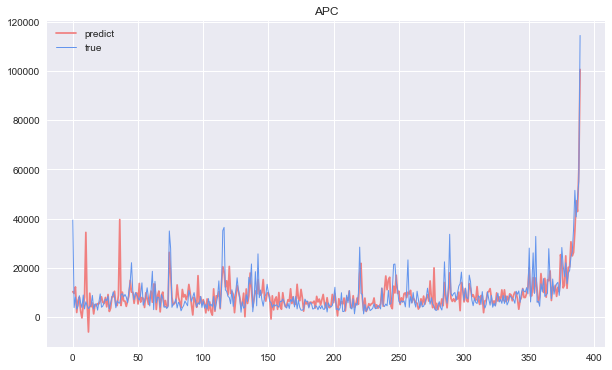

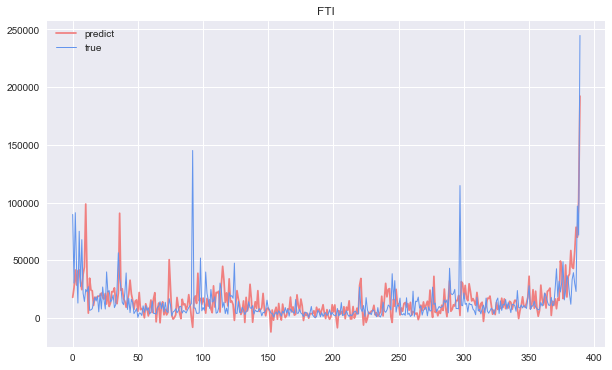

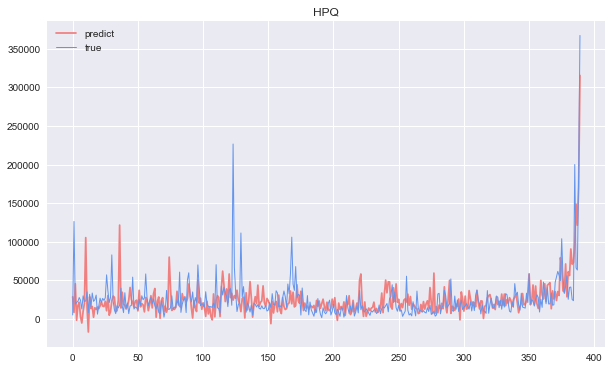

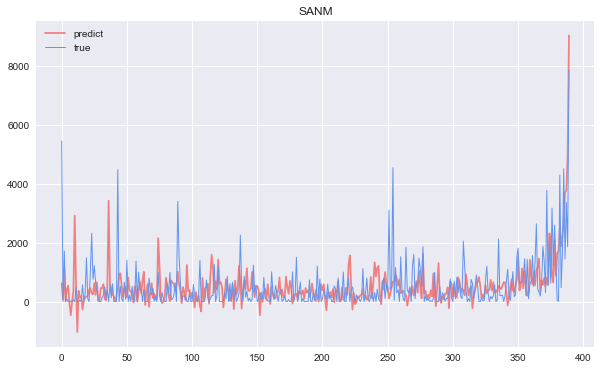

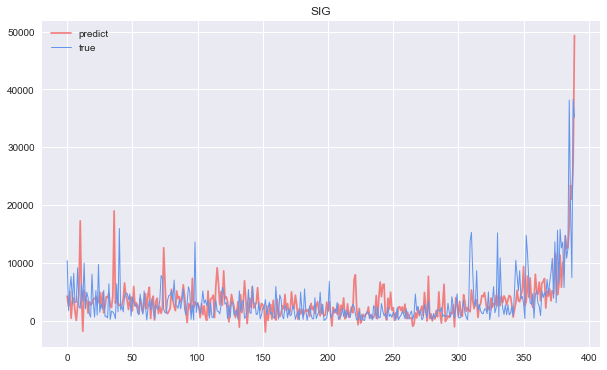

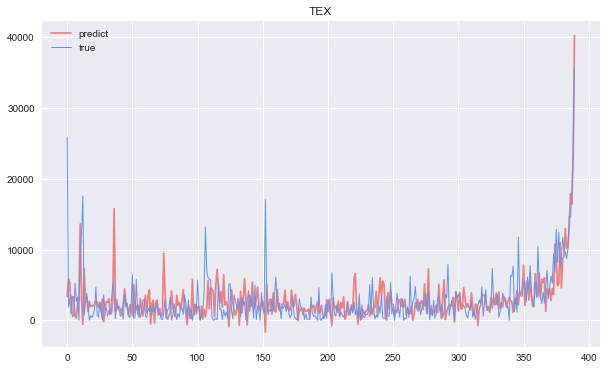

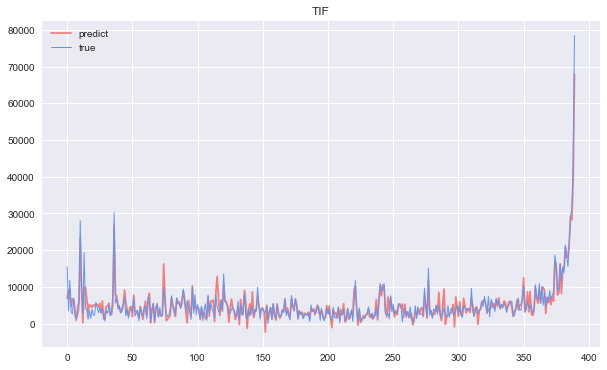

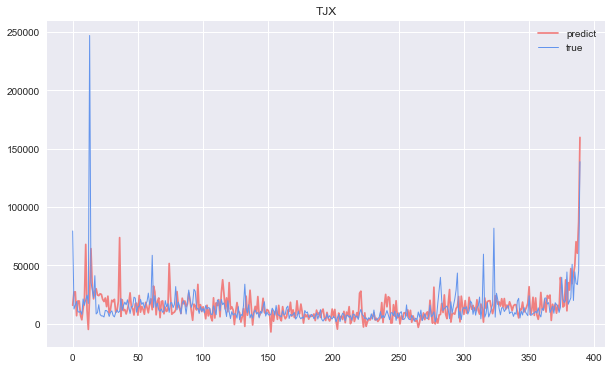

In [14]:
x = np.array(table[0:])
for i in range(y.shape[0]):
    plt.style.use('seaborn')
    plt.figure(figsize = (10,6),)
    plt.grid(True)
    plt.plot(x_pre[i], color = 'lightcoral')
    plt.plot(x[:,i], color = 'cornflowerblue', linewidth = 1)
    plt.title(table.columns[i])
    plt.legend(['predict', 'true'])
    plt.savefig(table.columns[i] + ".png")

# Volume Percentage Prediction

In [31]:
max_ = x_pre.max(axis=1)
min_ = x_pre.min(axis=1)
for i in range(x_pre.shape[0]):
    for j in range(x_pre.shape[1]):
        x_pre[i][j] = (x_pre[i][j]-min_[i])/(max_[i]-min_[i])
#         x_pre[i][j]=max(0,x_pre[i][j])
x_pre_sum = x_pre.sum(axis=1)
for i in range(x_pre.shape[0]):
    for j in range(x_pre.shape[1]):
        x_pre[i][j] = x_pre[i][j]/x_pre_sum[i]
x_pre.shape, x_pre_sum.shape

((8, 390), (8,))

In [32]:
x = np.array(table[0:])
x.shape
x_sum = x.sum(axis=0)
x_sum
x_true=np.zeros(shape=x.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        x_true[i][j] = x[i][j]/x_sum[j]
# x_true

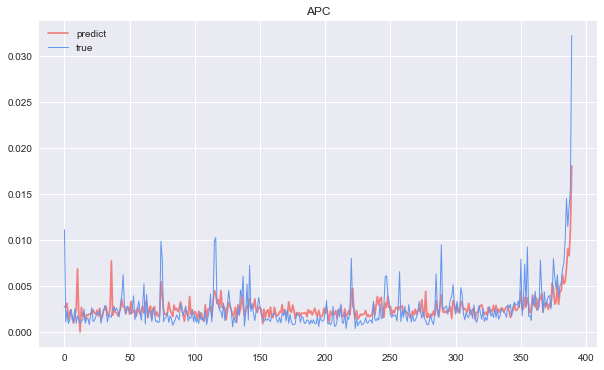

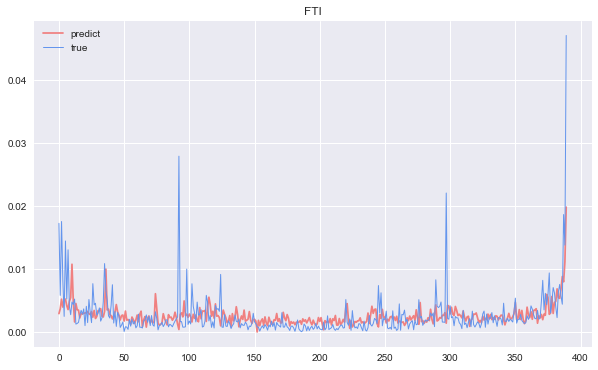

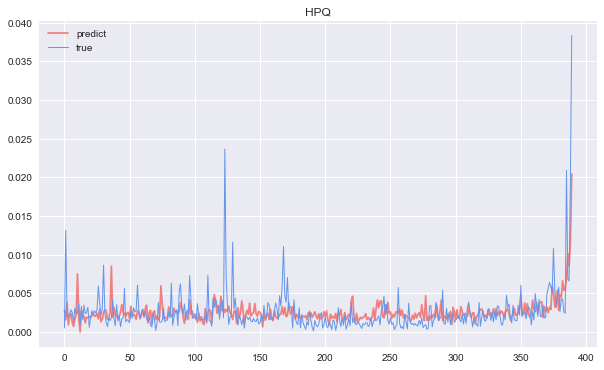

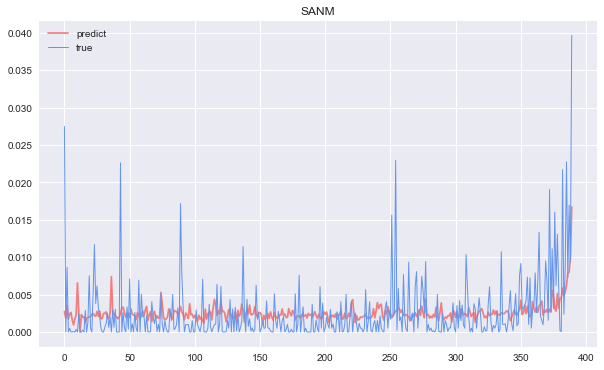

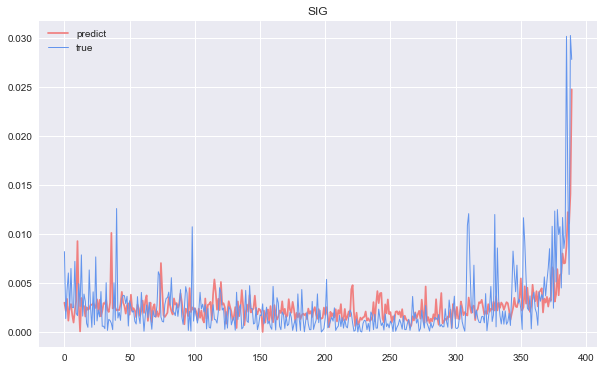

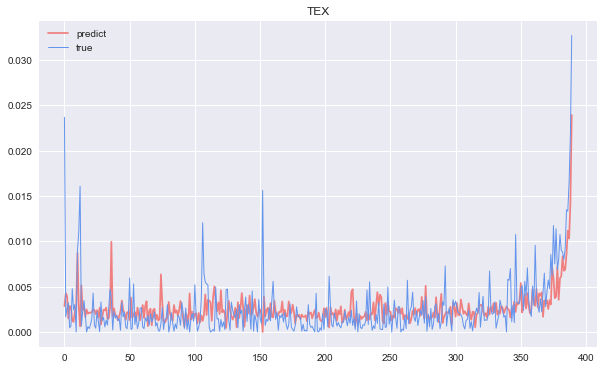

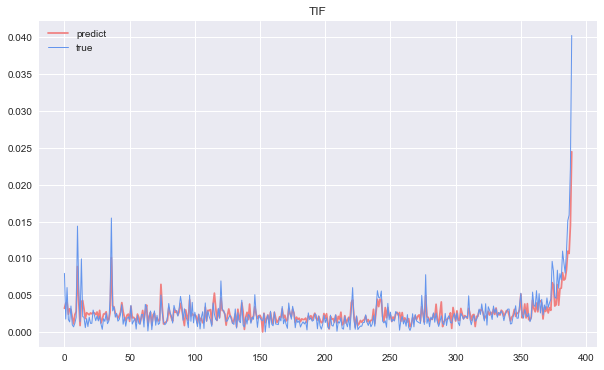

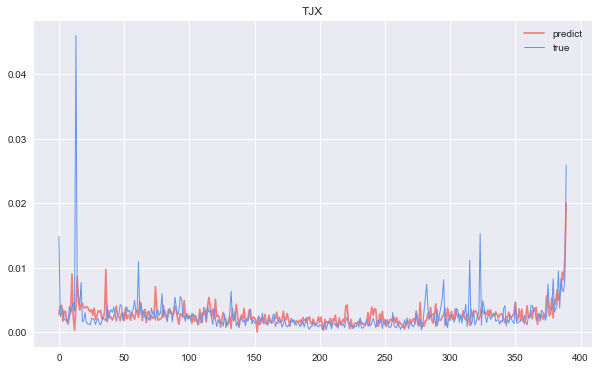

In [17]:
for i in range(y.shape[0]):
    plt.style.use('seaborn')
    plt.figure(figsize = (10,6),)
    plt.grid(True)
    plt.plot(x_pre[i], color = 'lightcoral')
    plt.plot(x_true[:,i], color = 'cornflowerblue', linewidth = 1)
    plt.title(table.columns[i])
    plt.legend(['predict', 'true'])
    plt.savefig(table.columns[i] + "_pct.png")